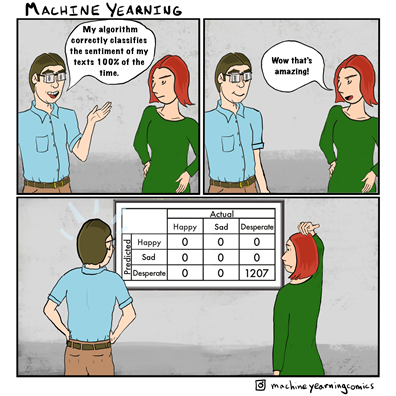

**Аффтар:** Матвей

**Цель:** Кластеризовать данные, сгенерировать на их основе новые фичи, встроить это все в pipeline и оценить эффект

**Библиотеки** : `Sklearn`

In [157]:
import numpy as np
import pandas as pd
import sklearn 
import sklearn.cluster
import warnings
warnings.filterwarnings('ignore')

In [158]:
X_train = pd.read_parquet('../datasets/01_german/samples/X_train.parquet')
y_train = pd.read_parquet('../datasets/01_german/samples/y_train.parquet').target

# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

X_test  = pd.read_parquet('../datasets/01_german/samples/X_test.parquet')
y_test  = pd.read_parquet('../datasets/01_german/samples/y_test.parquet').target

In [160]:
#Будем здесь использовать только количественные переменные, чтобы не перегружать pipeline onehot ecoding и др
X_train = X_train[['dur_t', 'cred_amt', 'inst_to_income', 'residence_t', 'age', 'n_loans', 'n_depend']]
X_test = X_test[['dur_t', 'cred_amt', 'inst_to_income', 'residence_t', 'age', 'n_loans', 'n_depend']]

# Начало
У меня есть две версии, как использовать кластеризацию: 1) просто сделать дополнительный столбец с присвоенными labels, 2) У некоторых моделей кластеризации есть свой transorm, который показывает расстояние до центра - интересно попробовать это тоже добавить в качестве фичей

[Очень крутой гайд практически по всем методам кластеризации](https://scikit-learn.org/stable/modules/clustering.html#birch)
Например, эта крутая картинка оттуда 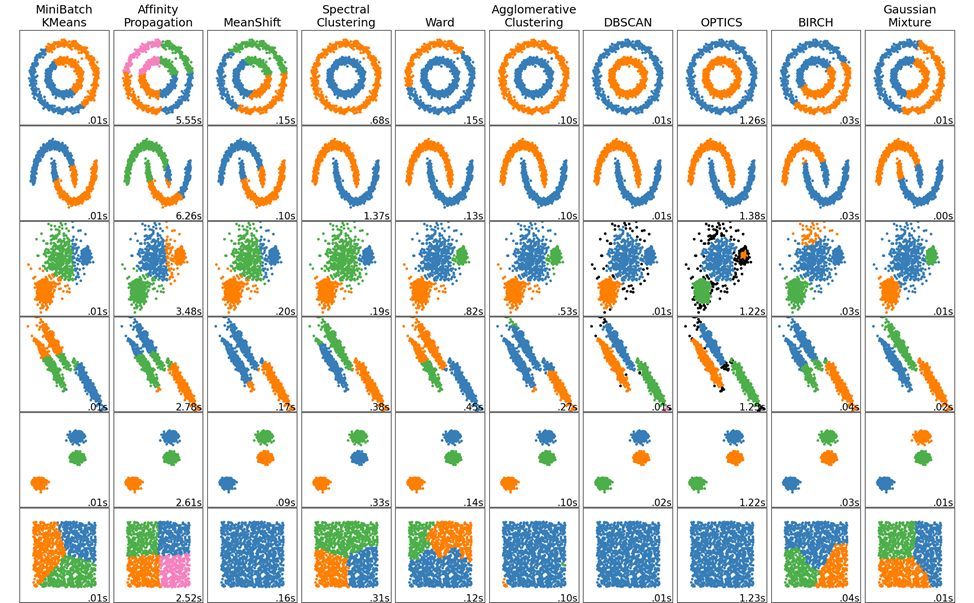

## [k_means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html#sklearn.cluster.k_means)

Самый популярный метод кластеризации - рандомно ставим центры, страемся разделить на кластеры с равным variance, минимизируя within-cluster sum-of-squares. Метод `transform` есть - он показывает расстояние точки до центра кластера

In [161]:
class KMeans_adj():
    def __init__(self, **kwargs):
        self.kmeans = sklearn.cluster.KMeans(**kwargs)
        
    def fit(self, X, y = None):
        self.kmeans.fit(X, y = None)
        return self
    
    def transform(self, X):
        # potentially 
        return pd.concat([
            pd.concat([X, pd.DataFrame(self.kmeans.transform(X), index = X.index)], axis=1),
            pd.DataFrame(self.kmeans.fit(X).labels_, index = X.index, columns = ['labels'])], axis = 1)
    
    def set_params(self, **kwargs):
        self.kmeans.set_params(**kwargs)
        return self 

In [162]:
KMeans = KMeans_adj(n_clusters = 2, #Число кластеров
                   init = 'k-means++', #Метод установки первых точек
                   algorithm = 'auto') #Какой алгоритм юзать

KMeans.fit(df)
pd.DataFrame(KMeans.transform(df))

,dur_t,cred_amt,inst_to_income,residence_t,age,n_loans,n_depend,0,1,labels
0,60,6836,3,4,63,2,1,1777.007691,4599.375606,1
1,21,2319,2,1,33,1,1,6293.639046,82.207134,0
2,6,1236,2,4,50,1,1,7376.689211,1001.082184,0
3,21,5003,1,4,29,2,1,3609.656506,2766.112728,0
4,12,886,4,2,21,1,1,7726.671878,1350.987874,0
...,...,...,...,...,...,...,...,...,...,...
795,18,6458,2,4,39,2,2,2154.685281,4221.105260,1
796,18,2662,4,3,32,1,1,5950.647836,425.117293,0
797,24,5804,4,2,27,2,1,2808.659744,3567.117596,1
798,12,1484,2,1,25,1,1,7128.668172,752.996884,0


## [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans)

Вариант k-means, использует mini-batches чтобы снизизить вычислительное время, но чуть страдает качество. Метод `transform` есть - работает аналогично k-means

In [163]:
class MiniBatchKMeans_adj():
    def __init__(self, **kwargs):
        self.batch = sklearn.cluster.MiniBatchKMeans(**kwargs)
        
    def fit(self, X, y = None):
        self.batch.fit(X, y = None)
        return self
    
    def transform(self, X):
        # potentially 
        return pd.concat([
            pd.concat([X, pd.DataFrame(self.batch.transform(X), index = X.index)], axis=1),
            pd.DataFrame(self.batch.fit(X).labels_, index = X.index, columns = ['labels'])], axis = 1)
    
    def set_params(self, **kwargs):
        self.batch.set_params(**kwargs)
        return self 

In [164]:
MiniBatch = MiniBatchKMeans_adj(n_clusters = 2, #Число кластеров
                               init = 'k-means++', #Метод установки первых точек
                               batch_size = 1024, #Размер Batch
                               reassignment_ratio = 0.01) #Параметр регуляризации

MiniBatch.fit(df)
pd.DataFrame(MiniBatch.transform(df))

,dur_t,cred_amt,inst_to_income,residence_t,age,n_loans,n_depend,0,1,labels
0,60,6836,3,4,63,2,1,4683.285682,1386.995040,1
1,21,2319,2,1,33,1,1,166.073294,5903.503483,0
2,6,1236,2,4,50,1,1,917.181381,6986.555609,0
3,21,5003,1,4,29,2,1,2850.025886,3219.522505,0
4,12,886,4,2,21,1,1,1267.080427,7336.537094,0
...,...,...,...,...,...,...,...,...,...,...
795,18,6458,2,4,39,2,2,4305.018137,1764.558482,1
796,18,2662,4,3,32,1,1,509.028300,5560.512466,0
797,24,5804,4,2,27,2,1,3651.030852,2418.527186,1
798,12,1484,2,1,25,1,1,669.095124,6738.533337,0


## [BIRCH](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html#sklearn.cluster.Birch)

Дальнейшее развитие k-means - сравнение с minibatch можно найти в гайде в самом начале. По опыту работы с этим методом могу сказать, что он один из самых гибких, благодаря гиперпараметрам `branching_factor` и `threshold`. Однако здесь очень своеобразно работает метод `transform` - он показывает расстояние от точки до центра субкластера - а их может быть очень много, например, в примере внизу их столько же, сколько и точек - 800, в итоге мы получаем, что у нас фичей больше, чем наблюдений, что нехорошо, но вероятно сильно поможет PCA

In [165]:
class Birch_adj():

    def __init__(self, **kwargs):
        self.birch = sklearn.cluster.Birch(**kwargs)
        
    def fit(self, X, y = None):
        self.birch.fit(X, y = None)
        return self
    
    def transform(self, X):
        # potentially 
        return pd.concat([
            pd.concat([X, pd.DataFrame(self.birch.transform(X), index = X.index)], axis=1),
            pd.DataFrame(self.birch.fit(X).labels_, index = X.index, columns = ['labels'])], axis = 1)
    
    def set_params(self, **kwargs):
        self.birch.set_params(**kwargs)
        return self 

In [172]:
Birch = Birch_adj(n_clusters = 2,
                  branching_factor = 50,
                  threshold = 0.5)

Birch.fit(df)
pd.DataFrame(Birch.transform(df))

,dur_t,cred_amt,inst_to_income,residence_t,age,n_loans,n_depend,0,1,2,...,791,792,793,794,795,796,797,798,799,labels
0,60,6836,3,4,63,2,1,3858.503596,3840.409744,3456.553630,...,7343.104248,4138.235614,9109.003403,5553.113181,7482.041299,5844.223473,5102.183748,9021.054262,5776.072541,0
1,21,2319,2,1,33,1,1,659.172967,677.138095,1061.144665,...,11860.014629,8655.016176,13626.063261,10070.012463,11999.033586,10361.001062,9619.002651,13538.012151,10293.020985,1
2,6,1236,2,4,50,1,1,1742.094429,1760.347693,2144.042910,...,12943.057714,9738.076247,14709.080529,11153.047969,13082.036577,11444.027482,10702.020931,14621.032487,11376.040040,1
3,21,5003,1,4,29,2,1,2025.059011,2007.022920,1623.112134,...,9176.018200,5971.020683,10942.088420,7386.019632,9315.054911,7677.000716,6935.008075,10854.019532,7609.036207,0
4,12,886,4,2,21,1,1,2092.039675,2110.036256,2494.066358,...,13293.030655,10088.029837,15059.104190,11503.036729,13432.069684,11794.007037,11052.021489,14971.035569,11726.053982,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,18,6458,2,4,39,2,2,3480.028736,3462.057625,3078.034275,...,7721.034128,4516.055580,9487.087488,5931.027904,7860.041857,6222.007715,5480.003376,9399.018247,6154.031687,0
796,18,2662,4,3,32,1,1,316.243577,334.276831,718.163630,...,11517.019406,8312.021776,13283.074305,9727.018454,11656.040751,10018.000699,9276.004905,13195.017014,9950.028141,1
797,24,5804,4,2,27,2,1,2826.063517,2808.010328,2424.105608,...,8375.014209,5170.014023,10141.092052,6585.019590,8514.061369,6876.001672,6134.012227,10053.020193,6808.041055,0
798,12,1484,2,1,25,1,1,1494.029116,1512.058861,1896.055379,...,12695.030248,9490.030716,14461.098990,10905.033471,12834.062529,11196.005314,10454.016549,14373.031448,11128.048122,1


## [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)

Один из самых модных сейчас методов кластеризации - его плюс в том, что он может найти кластеры абсолютно любой формы, отчего картинки с иллюстрацией его работы получаются очень крутые, однако его эффективность в работе с реальными экономическими данными вызывает вопросы - зачастую он проигрывает простейшим моделям. К сожалению, метода `transform` нет

In [167]:
class DBSCAN_adj():

    def __init__(self, **kwargs):
        self.dbscan = sklearn.cluster.DBSCAN(**kwargs)
        
    def fit(self, X, y = None):
        self.dbscan.fit(X, y = None)
        return self
    
    def transform(self, X):
        # potentially 
        return pd.concat([X, pd.DataFrame(self.dbscan.fit(X).labels_, index = X.index)], axis=1)
    
    def set_params(self, **kwargs):
        self.dbscan.set_params(**kwargs)
        return self 

In [168]:
DBSC = DBSCAN_adj()

DBSC.fit(df)
pd.DataFrame(DBSC.transform(df))

,dur_t,cred_amt,inst_to_income,residence_t,age,n_loans,n_depend,0
0,60,6836,3,4,63,2,1,-1
1,21,2319,2,1,33,1,1,-1
2,6,1236,2,4,50,1,1,-1
3,21,5003,1,4,29,2,1,-1
4,12,886,4,2,21,1,1,-1
...,...,...,...,...,...,...,...,...
795,18,6458,2,4,39,2,2,-1
796,18,2662,4,3,32,1,1,-1
797,24,5804,4,2,27,2,1,-1
798,12,1484,2,1,25,1,1,-1


## Другие методы

Из других методов кластеризации заслуживают внимание [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering), [MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift), [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS), их можно попробовать, но у всех у них нет метода, что снижает эффективность их использования

# Встраивание в pipeline

Обязательно встраиваем в каждый pipeline scaling, так как без них кластеризация значительно хуже работает

In [169]:
#Оборачиваем scaling для его корректной работы
class StScal_adj():
    def __init__(self, **kwargs):
        self.stscal = sklearn.preprocessing.StandardScaler(**kwargs)
        
    def fit(self, X, y = None):
        self.stscal.fit(X, y = None)
        return self
    
    def transform(self, X):
        # potentially 
        return  pd.DataFrame(self.stscal.transform(X), columns = list(X.columns))
    
    def set_params(self, **kwargs):
        self.stscal.set_params(**kwargs)
        return self 

In [170]:
#Подготовка pipeline
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

X_train = X_train[['dur_t', 'cred_amt', 'inst_to_income', 'residence_t', 'age', 'n_loans', 'n_depend']]
X_test = X_test[['dur_t', 'cred_amt', 'inst_to_income', 'residence_t', 'age', 'n_loans', 'n_depend']]
def Gini(y, y_pred):
    res = roc_auc_score(y, y_pred) * 2 - 1
    print(f"Gini: {res}")
    return(res)

In [171]:
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 10,
    learning_rate = .1,
    reg_alpha = 8,
    reg_lambda = 8,
    random_state = seed
)
StScal_mdl = StScal_adj()
KMeans_mdl = KMeans_adj(n_clusters = 2, random_state = seed)
MiniBatch_mdl = MiniBatchKMeans_adj(n_clusters = 2, random_state = seed)
Birch_mdl = Birch_adj(n_clusters = 2)
DBSC_mdl = DBSCAN_adj()



print('Без clustering')
mdl_pipe_impute = Pipeline(
    [('StScal', StScal_mdl), ('lgbm', lgbm_mdl)]
)
mdl_pipe_impute.fit(X_train, y_train)

Gini(y_train, mdl_pipe_impute.predict_proba(X_train)[:, 1])
Gini(y_test, mdl_pipe_impute.predict_proba(X_test)[:, 1])



print('KMeans')
mdl_pipe_impute = Pipeline(
    [('StScal', StScal_mdl), ('KMeans', KMeans_mdl), ('lgbm', lgbm_mdl)]
)
mdl_pipe_impute.fit(X_train, y_train)

Gini(y_train, mdl_pipe_impute.predict_proba(X_train)[:, 1])
Gini(y_test, mdl_pipe_impute.predict_proba(X_test)[:, 1])



print('MiniBatch')
mdl_pipe_impute = Pipeline(
    [('StScal', StScal_mdl), ('MiniBatch', MiniBatch_mdl), ('lgbm', lgbm_mdl)]
)
mdl_pipe_impute.fit(X_train, y_train)

Gini(y_train, mdl_pipe_impute.predict_proba(X_train)[:, 1])
Gini(y_test, mdl_pipe_impute.predict_proba(X_test)[:, 1])



print('Birch')
mdl_pipe_impute = Pipeline(
    [('StScal', StScal_mdl), ('Birch',Birch_mdl), ('lgbm', lgbm_mdl)]
)
mdl_pipe_impute.fit(X_train, y_train)

Gini(y_train, mdl_pipe_impute.predict_proba(X_train)[:, 1])
Gini(y_test, mdl_pipe_impute.predict_proba(X_test)[:, 1])



print('DBSCAN')
mdl_pipe_impute = Pipeline(
    [('StScal', StScal_mdl), ('DBSC',DBSC_mdl), ('lgbm', lgbm_mdl)]
)
mdl_pipe_impute.fit(X_train, y_train)

Gini(y_train, mdl_pipe_impute.predict_proba(X_train)[:, 1])
Gini(y_test, mdl_pipe_impute.predict_proba(X_test)[:, 1])

Без clustering
Gini: 0.47505548586316704
Gini: 0.311095083543695
KMeans
Gini: 0.5427593732138749
Gini: 0.34403173458348335
MiniBatch
Gini: 0.5496700539641772
Gini: 0.34871979805265063
Birch
Gini: 0.8030121957556098
Gini: 0.22586849380935203
DBSCAN
Gini: 0.4878005329612005
Gini: 0.30388267820651516


0.30388267820651516

# Выводы
1. Я везде использовал 2 кластера, так как у нас две итоговые категории, но с этим параметром тоже можно поиграться
1. С небольшими дополнительными махинациями все методы кластеринга смогли проползти в pipeline
1. Как видим, очень неплохо на тестовых данных показали себя k-means, MiniBatch, думаю, в первую очередь засчет их внутреннего метода transform 
1. На train очень хорошо себя показал Birch, но провалился на test. Может быть после тюнинга гиперпараметров, а также применения PCA, результат на тесте выправится